In [1]:
# utility
import os, os.path
import datetime as dt
from tqdm import tqdm

# data
import numpy as np
import pandas as pd

# image
import cv2 as cv2
import matplotlib.pyplot as plt


# Model
import tensorflow as tf
from keras.callbacks import EarlyStopping
from keras.layers import Flatten, Dense, Dropout
from keras.models import Sequential
from keras.applications.xception import preprocess_input
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC

from tpot import TPOTClassifier

c:\users\limmy\onedrive - nanyang technological university\documents\dropbox (personal)\ntu studies\cz4041 - machine learning\project\venv\lib\site-packages\tpot\builtins\__init__.py:36: UserWarning: Warning: optional dependency `torch` is not available. - skipping import of NN models.
  warnings.warn("Warning: optional dependency `torch` is not available. - skipping import of NN models.")


In [2]:
start = dt.datetime.now()

# Parameters


In [3]:
# Image size for Transfer Learning
img_width, img_height = 299, 299
batch_size = 16

# Path to data
# !!! SET WORKING DIRECTORY BEFORE RUNNING !!!
data_dir = ""

sub_samples = 0  

# Train-Validation Split
split = 0.2

detourage = True
nl_means = False     

# Set seed
seed = 4041

# Data

In [4]:
train_data_dir = data_dir+"/train"
val_data_dir = train_data_dir
test_data_dir = data_dir+"/test"

labels = sorted(os.listdir(train_data_dir))
for label in labels:
    print(label, len([name for name in os.listdir(train_data_dir+'/'+label) if os.path.isfile(os.path.join(train_data_dir+'/'+label, name))]))

data_dir

Black-grass 263
Charlock 390
Cleavers 287
Common Chickweed 611
Common wheat 221
Fat Hen 475
Loose Silky-bent 654
Maize 221
Scentless Mayweed 516
Shepherds Purse 231
Small-flowered Cranesbill 496
Sugar beet 385


'C:/Users/LIMMY/OneDrive - Nanyang Technological University/Documents/Dropbox (Personal)/NTU Studies/CZ4041 - Machine Learning/Project/'

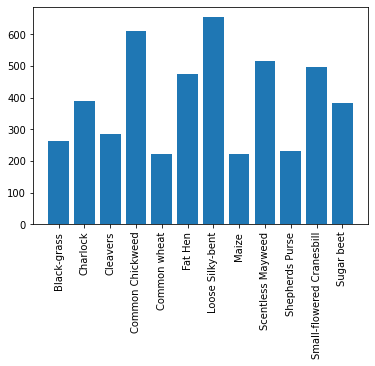

In [5]:
count_plot = []
for i in labels:
    count_plot.append(len(os.listdir(os.path.join(train_data_dir,i))))
count_plot = np.array(count_plot)
plt.bar(labels, count_plot)
plt.xticks(rotation = 90)
plt.show()

In [6]:
data = []
for category_id, category in enumerate(labels):
    for file in os.listdir(os.path.join(train_data_dir, category)):
        data.append([f'{train_data_dir}/{category}/{file}', category_id, category])
data = pd.DataFrame(data, columns=['filepath', 'category_id', 'category'])
display(data.head(2))
print(data.shape)

,filepath,category_id,category
0,C:/Users/LIMMY/OneDrive - Nanyang Technologica...,0,Black-grass
1,C:/Users/LIMMY/OneDrive - Nanyang Technologica...,0,Black-grass


(4750, 3)


In [7]:
test = []
for file in sorted(os.listdir(test_data_dir)):
    test.append([f'{test_data_dir}/{file}', file])
test = pd.DataFrame(test, columns=['filepath', 'file'])
display(test.head(2))
print(test.shape)

,filepath,file
0,C:/Users/LIMMY/OneDrive - Nanyang Technologica...,0021e90e4.png
1,C:/Users/LIMMY/OneDrive - Nanyang Technologica...,003d61042.png


(794, 2)


## Sub Sample

In [8]:
# Sub-sample for faster testing and avoiding memory overflow
if sub_samples > 0:
    data = pd.concat([data[data['category'] == c][:sub_samples] for c in labels])
    data = data.sample(frac=1)
    data.index = np.arange(len(data))
    display(data.head(2))
    print(data.shape)

## Train-Validation Split

In [9]:
stratified_split = True
if stratified_split:
    df_train_x, df_val_x, train_y, val_y = train_test_split(data['filepath'], data['category_id'], test_size=split, random_state=seed, stratify=data['category_id'])
    print(df_train_x.shape, df_val_x.shape, train_y.shape, val_y.shape)
else:
    np.random.seed(seed=seed)
    rnd = np.random.random(len(data))
    train_idx = rnd > split
    valid_idx = rnd <= split
    train_y = data.loc[train_idx, 'category_id'].values
    val_y = data.loc[valid_idx, 'category_id'].values
    df_train_x = data.loc[train_idx, 'filepath'].values
    df_val_x = data.loc[valid_idx, 'filepath'].values

print("{} images for train".format(len(df_train_x)))
print("{} images for validation".format(len(df_val_x)))

(3800,) (950,) (3800,) (950,)
3800 images for train
950 images for validation


# Preprocessing: Filter by colour since the seedlings are green

We convert the image to HSV (Hue-Saturation-Value) in order to be able to create a mask of the "green" areas, which is then applied to the image to clip it

   ![HSV](https://www.mathworks.com/help/images/hsvcone.gif)


In [10]:
def create_mask_for_plant(image):
    sensitivity=35
    image_hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    lower_hsv = np.array([60 - sensitivity, 100, 50])
    upper_hsv = np.array([60 + sensitivity, 255, 255])

    mask = cv2.inRange(image_hsv, lower_hsv, upper_hsv)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (11,11))
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    return mask

def segment_plant(image):
    mask = create_mask_for_plant(image)
    output = cv2.bitwise_and(image, image, mask = mask)
    return output

def sharpen_image(image):
    image_blurred = cv2.GaussianBlur(image, (0, 0), 3)
    image_sharp = cv2.addWeighted(image, 1.5, image_blurred, -0.5, 0)
    return image_sharp

In [11]:
def preprocessing_cnn(img, mask_grass=False, nl_means=False):
    if mask_grass:
        img_segmented = segment_plant(img)
        img = sharpen_image(img_segmented)
    if nl_means:
        # Apply non-local means filter on test image
        img = cv2.fastNlMeansDenoisingColored(
            src=img.astype(np.uint8),
            dst=None,
            h=10,
            hColor=10,
            templateWindowSize=7,
            searchWindowSize=21)
    return img

def show_image_preprocc(image):
    image_mask = create_mask_for_plant(image)
    image_segmented = segment_plant(image)
    image_sharpen = sharpen_image(image_segmented)
    image_nlmeans = preprocessing_cnn(image_sharpen, nl_means=True)
    fig, axs = plt.subplots(1, 5, figsize=(20, 20))
    axs[0].imshow(image)
    axs[1].imshow(image_mask)
    axs[2].imshow(image_segmented)
    axs[3].imshow(image_sharpen)
    axs[4].imshow(image_nlmeans)

## Overview of filters

    1st image: original
    2nd image: mask, based on HSV filter to select green
    3rd image: original image with mask applied
    4th image: application of a Gaussian filter on the 3rd image
             --> we use this one
    5th image: application of a Non-local Means filter on the 4th image
             --> it takes a lot of time and lowers the final score, so we won't use it

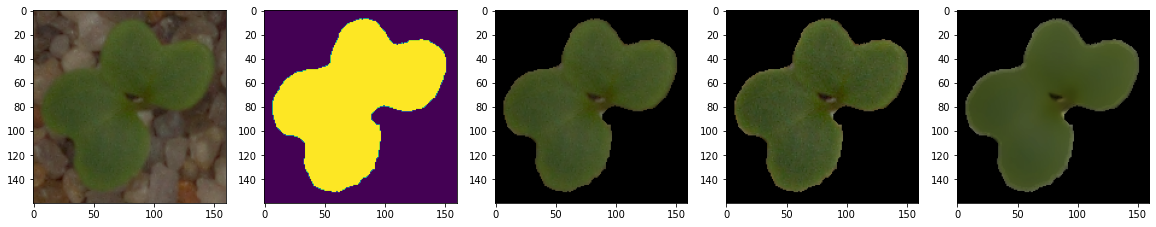

In [13]:
# Test image to see the changes, from a train sample
class_indix = 1
img_indix = 1

list_files_cat = data['filepath'][data['category_id']==class_indix].reset_index(drop=True)
image_path = list_files_cat[img_indix]

image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
show_image_preprocc(image)

# Traditional ML

In [14]:
pure_classifier = {}

def train_predict_score(model, train_x, train_y, val_x, val_y):
    t0 = dt.datetime.now()
    model.fit(train_x, train_y)
    val_preds = model.predict(val_x)
    val_probs = model.predict_proba(val_x)
    score = accuracy_score(val_y, val_preds)
    t = dt.datetime.now()-t0
    print('Train/Predict/Evaluate time: {} sec'.format(t.seconds))
    return val_preds, val_probs, score, t

In [15]:
raw_train_x = np.zeros((len(df_train_x), 6075), dtype='float32')
for i, file in tqdm(enumerate(df_train_x)):
    img = cv2.imread(file)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (45, 45))
    img = preprocessing_cnn(img, mask_grass=detourage, nl_means=nl_means)
    img = tf.keras.utils.img_to_array(img)
    img = img.flatten()
    x = preprocess_input(np.expand_dims(img, axis=0))
    raw_train_x[i] = x
print('Train Images shape: {} size: {:,}'.format(raw_train_x.shape, raw_train_x.size))

raw_val_x = np.zeros((len(df_val_x), 6075), dtype='float32')
for i, file in tqdm(enumerate(df_val_x)):
    img = cv2.imread(file)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (45, 45))
    img = preprocessing_cnn(img, mask_grass=detourage, nl_means=nl_means)
    img = tf.keras.utils.img_to_array(img)
    img = img.flatten()
    x = preprocess_input(np.expand_dims(img, axis=0))
    raw_val_x[i] = x
print('Validation Images shape: {} size: {:,}'.format(raw_val_x.shape, raw_val_x.size))

3800it [00:34, 110.16it/s]


Train Images shape: (3800, 6075) size: 23,085,000


950it [00:07, 118.90it/s]

Validation Images shape: (950, 6075) size: 5,771,250


## Random Forest

In [94]:
rfc = RandomForestClassifier(n_estimators=500)
val_pred, val_prob, score, t = train_predict_score(rfc, raw_train_x, train_y, raw_val_x, val_y)
print('Validation RandomForestClassifier Accuracy {}'.format(score))

pure_classifier['raw rfc'] = (rfc, val_pred, val_prob, score, t)

Train/Predict/Evaluate time: 63 sec
Validation RandomForestClassifier Accuracy 0.6736842105263158


## K-Nearest Neighbours

In [18]:
knn = KNeighborsClassifier(n_neighbors = 15)
val_pred, val_prob, score, t = train_predict_score(knn, raw_train_x, train_y, raw_val_x, val_y)
print('Validation Accuracy [KNN]: {}'.format(score))

pure_classifier['raw KNN'] = (knn, val_pred, val_prob, score, t)

Train/Predict/Evaluate time: 1 sec
Validation Accuracy [KNN]: 0.42105263157894735


In [19]:
def plot_acc_loss(hist, metrics = None):
    acc = hist.history['accuracy']
    val_acc = hist.history['val_accuracy']

    loss = hist.history['loss']
    val_loss = hist.history['val_loss']

    epochs_range = range(len(loss))

    num_subplot = 2
    if metrics is not None:
        num_subplot += len(metrics)

    plt.figure(figsize=(8+2*num_subplot, 8))
    plt.subplot(1, num_subplot, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    if val_acc is not None:
        plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, num_subplot, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    if val_loss is not None:
        plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')

    if metrics is not None:
        for i, met in enumerate(metrics):
            m = hist.history[met]
            val_m = hist.history['val_' + met]
            plt.subplot(1, num_subplot, 3+i)
            plt.plot(epochs_range, m, label='Training '+met)
            if val_m is not None:
                plt.plot(epochs_range, val_m, label='Validation '+met)
            plt.legend()
            plt.title('Training and Validation '+met)
        
    plt.show()

## Fully-Connected

Epoch 1/50
3800/3800 [==============================] - 47s 12ms/step - loss: 2.4237 - accuracy: 0.1429 - val_loss: 2.3504 - val_accuracy: 0.2137
Epoch 2/50
3800/3800 [==============================] - 44s 11ms/step - loss: 2.3044 - accuracy: 0.1832 - val_loss: 2.1970 - val_accuracy: 0.2463
Epoch 3/50
3800/3800 [==============================] - 43s 11ms/step - loss: 2.1956 - accuracy: 0.2213 - val_loss: 2.1509 - val_accuracy: 0.2579
Epoch 4/50
3800/3800 [==============================] - 34s 9ms/step - loss: 2.1437 - accuracy: 0.2339 - val_loss: 2.0557 - val_accuracy: 0.2916
Epoch 5/50
3800/3800 [==============================] - 36s 9ms/step - loss: 2.1056 - accuracy: 0.2495 - val_loss: 2.0151 - val_accuracy: 0.2947
Epoch 6/50
3800/3800 [==============================] - 35s 9ms/step - loss: 2.0802 - accuracy: 0.2629 - val_loss: 2.0339 - val_accuracy: 0.2989
Epoch 7/50
3800/3800 [==============================] - 38s 10ms/step - loss: 2.0493 - accuracy: 0.2687 - val_loss: 1.9596 - va

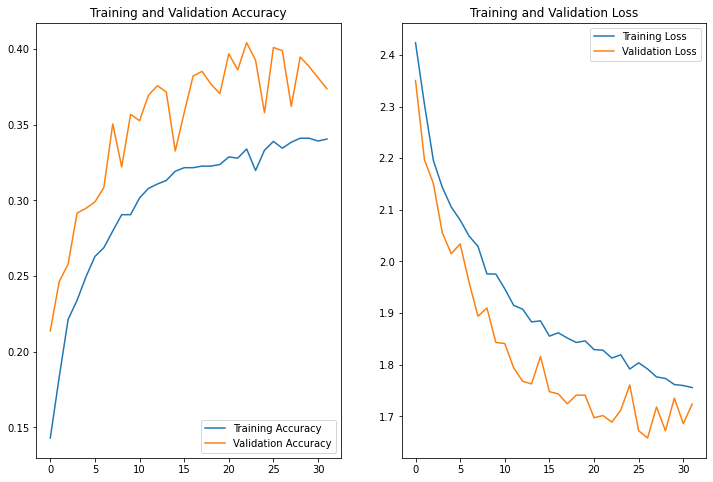

Validation Fully-connected Accuracy 0.3736842105263158


In [61]:
fully_connected = Sequential([
    Flatten(),
    Dense(100, activation='relu'),
    tf.keras.layers.BatchNormalization(trainable = False, axis=1),
    Dropout(0.2),
    Dense(50, activation='relu'),
    Dense(len(labels), activation='softmax')
])

optimizer = tf.keras.optimizers.Nadam(learning_rate=0.00004, beta_1=0.9, beta_2=0.999)
fully_connected.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

t0 = dt.datetime.now()
history = fully_connected.fit(
    x = raw_train_x,
    y = train_y,
    steps_per_epoch= raw_train_x.shape[0],
    epochs=50,
    validation_data=(raw_val_x, val_y),
    validation_steps=raw_val_x.shape[0],
    callbacks=[EarlyStopping(monitor='val_loss', patience=5)]
)

fc_valid_preds_res = fully_connected.predict(raw_val_x)
fc_valid_preds = np.argmax(fc_valid_preds_res, axis=1)
fc_valid_probs = np.max(fc_valid_preds_res, axis=1)
fc_score = accuracy_score(val_y, fc_valid_preds)
t = dt.datetime.now()-t0
print('Train/Predict/Evaluate time: {} sec'.format(t.seconds))
plot_acc_loss(history)
print('Validation Fully-connected Accuracy {}'.format(fc_score))

pure_classifier['raw fc'] = (fully_connected, fc_valid_preds, fc_valid_probs, fc_score, t)

## Convolutional Neural Network (CNN)

In [21]:
mlp = MLPClassifier(hidden_layer_sizes=(300, 200,), random_state=seed, max_iter=1000)
val_pred, val_prob, score, t = train_predict_score(mlp, raw_train_x, train_y, raw_val_x, val_y)
print(f'Validation Accuracy [CNN]: {score}')

pure_classifier['raw CNN'] = (mlp, val_pred, val_prob, score, t)

Train/Predict/Evaluate time: 171 sec
Validation Accuracy [CNN]: 0.6021052631578947


## SVM (Linear)

In [65]:
def svm_helper(model, train_x, train_y, val_x, val_y):
    t0 = dt.datetime.now()
    model.fit(train_x, train_y)
    val_preds = model.predict(val_x)
    score = accuracy_score(val_y, val_preds)
    t = dt.datetime.now()-t0
    print(f'Train/Predict/Evaluate time: {t.seconds} sec')
    return val_preds, score, t

In [66]:
linear = SVC(kernel='linear', C=1, decision_function_shape='ovo', random_state=seed)
val_pred, score, t = svm_helper(linear, raw_train_x, train_y, raw_val_x, val_y)
print(f'Validation Accuracy [SVM_linear]: {score}')

pure_classifier['raw SVM_linear'] = (linear, val_pred, None, score, t)

Train/Predict/Evaluate time: 59 sec
Validation Accuracy [Xception+SVM_linear]: 0.5736842105263158


# Random Forest + TPOT

In [22]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt','log2']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 1000,10)]
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10,14]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4,6,8]
# Create the random grid
param = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
              'criterion':['entropy','gini']}
print(param)

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt', 'log2'], 'max_depth': [10, 120, 230, 340, 450, 560, 670, 780, 890, 1000], 'min_samples_split': [2, 5, 10, 14], 'min_samples_leaf': [1, 2, 4, 6, 8], 'criterion': ['entropy', 'gini']}


In [23]:
tpot_classifier = TPOTClassifier(generations= 5, population_size= 24, offspring_size= 12,
                                 verbosity= 2, early_stop= 12,
                                 config_dict={'sklearn.ensemble.RandomForestClassifier': param}, 
                                 cv = 4, scoring = 'accuracy')
tpot_classifier.fit(raw_train_x,train_y)

Optimization Progress:   0%|          | 0/84 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.6442105263157895

Generation 2 - Current best internal CV score: 0.6442105263157895

Generation 3 - Current best internal CV score: 0.6442105263157895

Generation 4 - Current best internal CV score: 0.6481578947368422

Generation 5 - Current best internal CV score: 0.6481578947368422

Best pipeline: RandomForestClassifier(CombineDFs(RandomForestClassifier(input_matrix, criterion=gini, max_depth=120, max_features=log2, min_samples_leaf=6, min_samples_split=14, n_estimators=600), input_matrix), criterion=gini, max_depth=560, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=2000)


TPOTClassifier(config_dict={'sklearn.ensemble.RandomForestClassifier': {'criterion': ['entropy',
                                                                                      'gini'],
                                                                        'max_depth': [10,
                                                                                      120,
                                                                                      230,
                                                                                      340,
                                                                                      450,
                                                                                      560,
                                                                                      670,
                                                                                      780,
                                                                                 

In [24]:
accuracy = tpot_classifier.score(raw_val_x, val_y)
print(accuracy)

0.6673684210526316


In [25]:
pure_classifier['rfc + TPOT'] = (tpot_classifier, 0, 0, accuracy, 0)

In [98]:
best_score = 0.0
best_classifier = ''
print("classifier \t score \t\t")
for key in pure_classifier:
    score = pure_classifier[key][3]
    print(f"{key}\t{score}\t")

    if score > best_score:
        best_score = score
        best_classifier = key
print(f"\nBest classifier: {best_classifier}  - score: {best_score}")

classifier 	 score 		
raw KNN	0.42105263157894735	
raw fc	0.3736842105263158	
raw CNN	0.6021052631578947	
rfc + TPOT	0.6673684210526316	
raw SVM_linear	0.5736842105263158	
raw rfc	0.6736842105263158	

Best classifier: raw rfc  - score: 0.6736842105263158


# Xception Preprocessing

Read image with OpenCV, convert to RGB (OpenCV use BGR), resize, custom preprocess, Xception preprocess

### Trainset

In [27]:
train_x = np.zeros((len(df_train_x), img_width, img_height, 3), dtype='float32')
for i, file in tqdm(enumerate(df_train_x)):
    img = cv2.imread(file)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (img_width, img_height))
    img = preprocessing_cnn(img, mask_grass=detourage, nl_means=nl_means)
    img = tf.keras.utils.img_to_array(img)
    x = preprocess_input(np.expand_dims(img, axis=0))
    train_x[i] = x
print('Train Images shape: {} size: {:,}'.format(train_x.shape, train_x.size))

3800it [01:24, 44.98it/s]

Train Images shape: (3800, 299, 299, 3) size: 1,019,171,400


### Validation Set

In [28]:
val_x = np.zeros((len(df_val_x), img_width, img_height, 3), dtype='float32')
for i, file in tqdm(enumerate(df_val_x)):
    img = cv2.imread(file)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (img_width, img_height))
    img = preprocessing_cnn(img, mask_grass=detourage, nl_means=nl_means)
    img = tf.keras.utils.img_to_array(img)
    x = preprocess_input(np.expand_dims(img, axis=0))
    val_x[i] = x
print('Validation Images shape: {} size: {:,}'.format(val_x.shape, val_x.size))

950it [00:22, 42.54it/s]

Validation Images shape: (950, 299, 299, 3) size: 254,792,850


# Feature Extraction using Transfer Learning Model Xception

In [70]:
transfer_model = tf.keras.applications.xception.Xception(include_top=False, weights='imagenet', pooling='avg', input_shape=(img_height, img_width, 3))

# Extract Features from dataset 
train_x_bf = transfer_model.predict(train_x, batch_size=batch_size, verbose=1)
val_x_bf = transfer_model.predict(val_x, batch_size=batch_size, verbose=1)
print('Xception train bottleneck features shape: {} size: {:,}'.format(train_x_bf.shape, train_x_bf.size))
print('Xception valid bottleneck features shape: {} size: {:,}'.format(val_x_bf.shape, val_x_bf.size))

feature_extract_done = True

60/60 [==============================] - 138s 2s/step
Xception train bottleneck features shape: (3800, 2048) size: 7,782,400
Xception valid bottleneck features shape: (950, 2048) size: 1,945,600


# Feature Extraction + Classifiers


In [71]:
classifier = {}

## Xception + Random Forest

In [72]:
rfc = RandomForestClassifier(n_estimators=500)
val_pred, val_prob, score, t = train_predict_score(rfc, train_x_bf, train_y, val_x_bf, val_y)
print(f'Validation Xception+RandomForestClassifier Accuracy {score}')

classifier['rfc'] = (rfc, val_pred, val_prob, score, t)

Train/Predict/Evaluate time: 54 sec
Validation Xception+RandomForestClassifier Accuracy 0.8621052631578947


## Xception + Fully-Connected

Epoch 1/30
3800/3800 [==============================] - 34s 9ms/step - loss: 1.4651 - accuracy: 0.5703 - val_loss: 0.8334 - val_accuracy: 0.7537
Epoch 2/30
3800/3800 [==============================] - 30s 8ms/step - loss: 0.7486 - accuracy: 0.7724 - val_loss: 0.5565 - val_accuracy: 0.8495
Epoch 3/30
3800/3800 [==============================] - 29s 8ms/step - loss: 0.5629 - accuracy: 0.8189 - val_loss: 0.4440 - val_accuracy: 0.8621
Epoch 4/30
3800/3800 [==============================] - 28s 7ms/step - loss: 0.4479 - accuracy: 0.8584 - val_loss: 0.4088 - val_accuracy: 0.8811
Epoch 5/30
3800/3800 [==============================] - 27s 7ms/step - loss: 0.3959 - accuracy: 0.8755 - val_loss: 0.3565 - val_accuracy: 0.8811
Epoch 6/30
3800/3800 [==============================] - 29s 8ms/step - loss: 0.3427 - accuracy: 0.8889 - val_loss: 0.3304 - val_accuracy: 0.8968
Epoch 7/30
3800/3800 [==============================] - 28s 7ms/step - loss: 0.3129 - accuracy: 0.8932 - val_loss: 0.3193 - val_ac

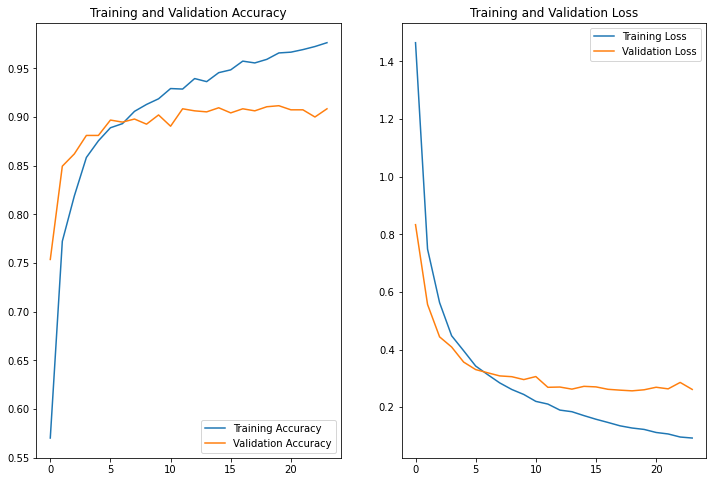

Validation Xception+Fully-connected Accuracy 0.9084210526315789


In [73]:
fully_connected = Sequential([
    Flatten(),
    Dense(100, activation='relu'),
    tf.keras.layers.BatchNormalization(trainable = False,axis=1),
    Dropout(0.2),
    Dense(50, activation='relu'),
    Dense(len(labels), activation='softmax')
])

optimizer = tf.keras.optimizers.Nadam(learning_rate=0.00004, beta_1=0.9, beta_2=0.999)
fully_connected.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

t0 = dt.datetime.now()
history = fully_connected.fit(
    x = train_x_bf,
    y = train_y,
    steps_per_epoch= train_x.shape[0],
    epochs=30,
    validation_data=(val_x_bf, val_y),
    validation_steps=val_x_bf.shape[0],
    callbacks=[EarlyStopping(monitor='val_loss', patience=5)]
)

fc_valid_preds_res = fully_connected.predict(val_x_bf)
fc_valid_preds = np.argmax(fc_valid_preds_res, axis=1)
fc_valid_probs = np.max(fc_valid_preds_res, axis=1)
fc_score = accuracy_score(val_y, fc_valid_preds)
t = dt.datetime.now()-t0
print(f'Train/Predict/Evaluate time: {t.seconds} sec')
plot_acc_loss(history)
print(f'Validation Xception+Fully-connected Accuracy {fc_score}')

classifier['fc'] = (fully_connected, fc_valid_preds, fc_valid_probs, fc_score, t)

## Xception + K Nearest Neighbours

In [74]:
knn = KNeighborsClassifier(n_neighbors = 15)
val_pred, val_prob, score, t = train_predict_score(knn, train_x_bf, train_y, val_x_bf, val_y)
print(f'Validation Accuracy [Xception+KNN]: {score}')

classifier['KNN'] = (knn, val_pred, val_prob, score, t)

Train/Predict/Evaluate time: 1 sec
Validation Accuracy [Xception+KNN]: 0.8547368421052631


## Xception + CNN

In [75]:
mlp = MLPClassifier(hidden_layer_sizes=(300, 200,), random_state=seed, max_iter=1000)
val_pred, val_prob, score, t = train_predict_score(mlp, train_x_bf, train_y, val_x_bf, val_y)
print(f'Validation Accuracy [Xception+CNN]: {score}')

classifier['CNN'] = (mlp, val_pred, val_prob, score, t)

Train/Predict/Evaluate time: 35 sec
Validation Accuracy [Xception+CNN]: 0.9094736842105263


## Xception + SVM (Linear)

In [76]:
linear = SVC(kernel='linear', C=1, decision_function_shape='ovo', random_state=seed)
val_pred, score, t = svm_helper(linear, train_x_bf, train_y, val_x_bf, val_y)
print(f'Validation Accuracy [Xception+SVM_linear]: {score}')

classifier['SVM_linear'] = (linear, val_pred, None, score, t)

Train/Predict/Evaluate time: 4 sec
Validation Accuracy [Xception+SVM_linear]: 0.9094736842105263


# Confusion Matrix and Accuracies for Xception + Other Model

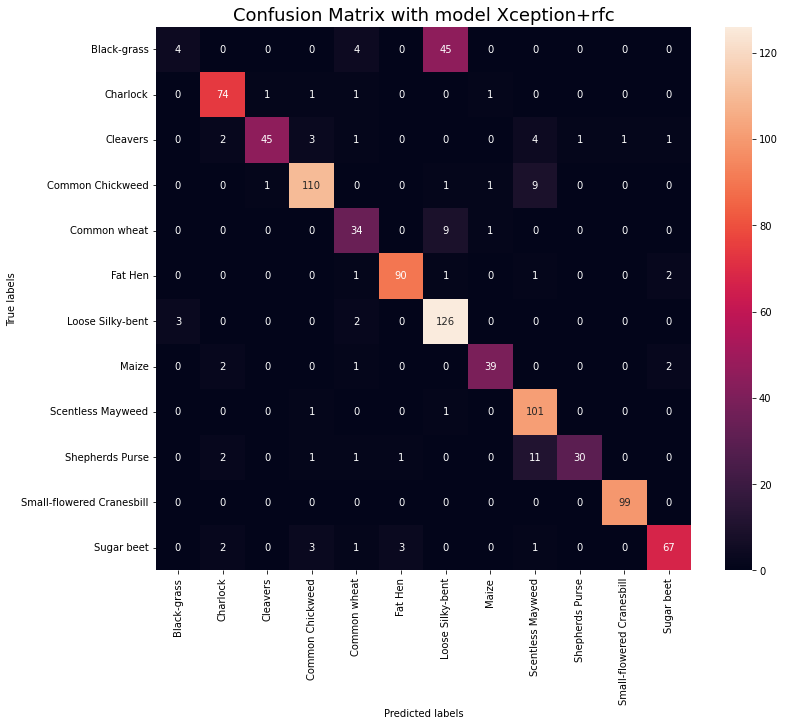

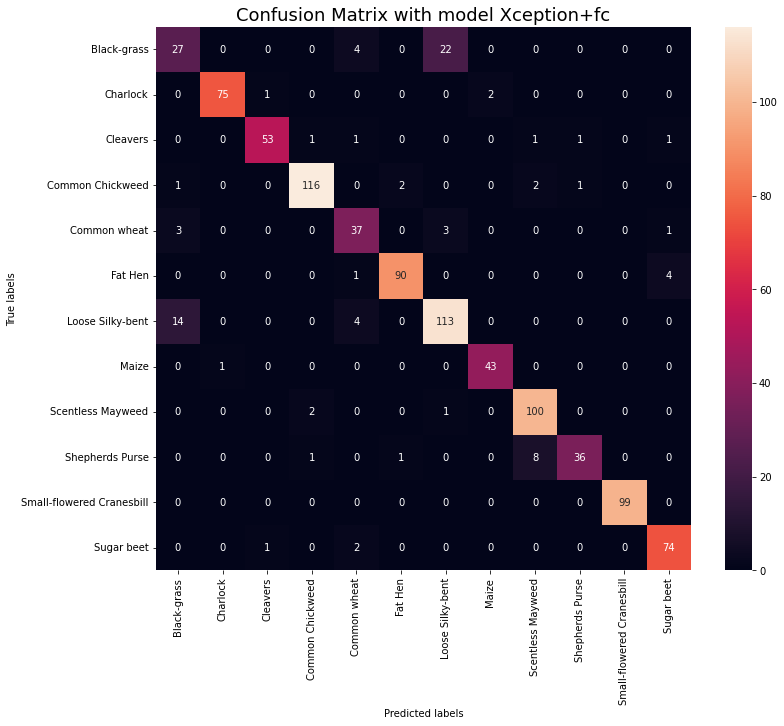

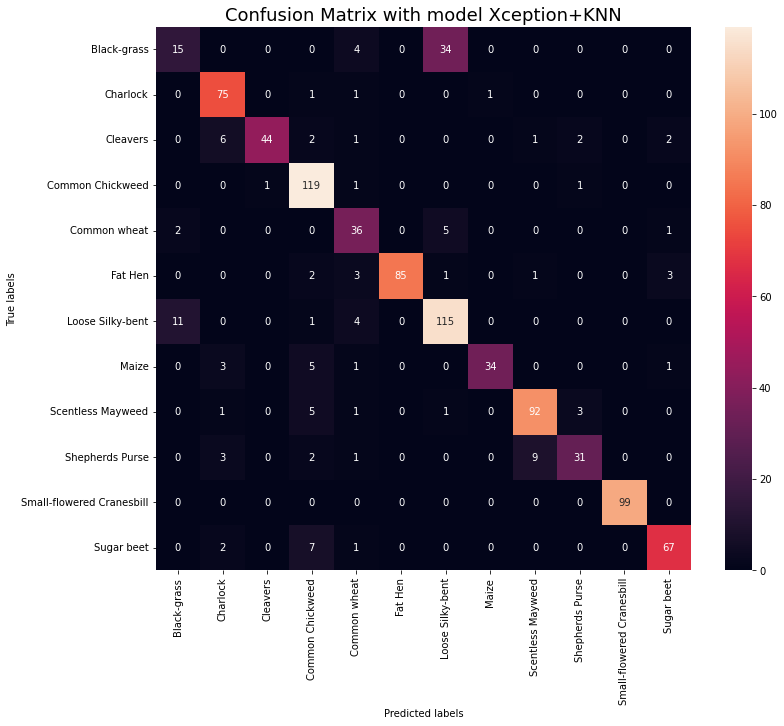

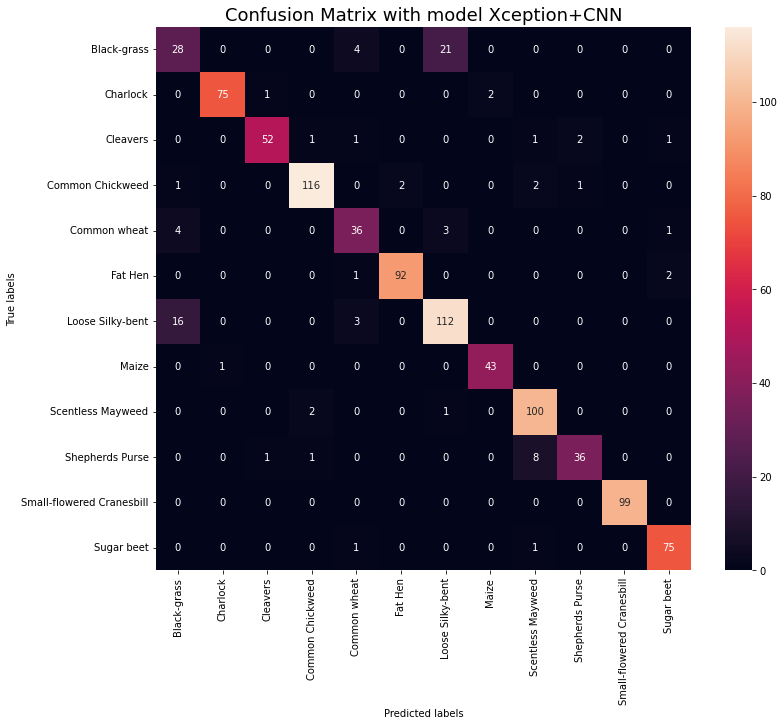

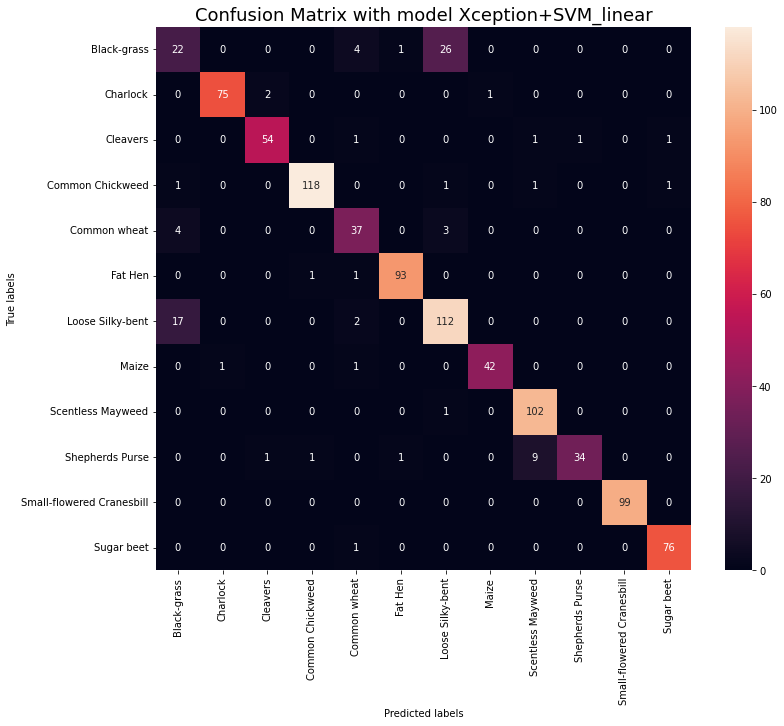

In [77]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

for key in classifier:
    # Use predictions
    y_pred = classifier[key][1]

    # Confusion Matrix
    cf_matrix = confusion_matrix(val_y, y_pred, labels=range(len(labels)))

    fig = plt.figure(figsize=(12,10))
    ax = sns.heatmap(cf_matrix, annot=True, fmt='d')
    ax.set_xlabel("Predicted labels")
    ax.set_ylabel("True labels")
    ax.xaxis.set_ticklabels(labels, rotation='vertical')
    ax.yaxis.set_ticklabels(labels, rotation='horizontal')
    plt.title("Confusion Matrix with model Xception+"+key, fontsize=18)
    plt.show()

In [78]:
best_score = 0.0
best_classifier = ''
print("classifier \t score \t\t time")
for key in classifier:
    score = classifier[key][3]
    print("{}\t{}\t{}".format(key, score, classifier[key][4]))
    if score > best_score:
        best_score = score
        best_classifier = key
print(f"\nBest classifier: {best_classifier}  - score: {best_score}")

classifier 	 score 		 time
rfc	0.8621052631578947	0:00:54.878044
fc	0.9084210526315789	0:11:25.575919
KNN	0.8547368421052631	0:00:01.018957
CNN	0.9094736842105263	0:00:35.611105
SVM_linear	0.9094736842105263	0:00:04.475162

Best classifier: CNN  - score: 0.9094736842105263


# Random Validation Samples Predictions

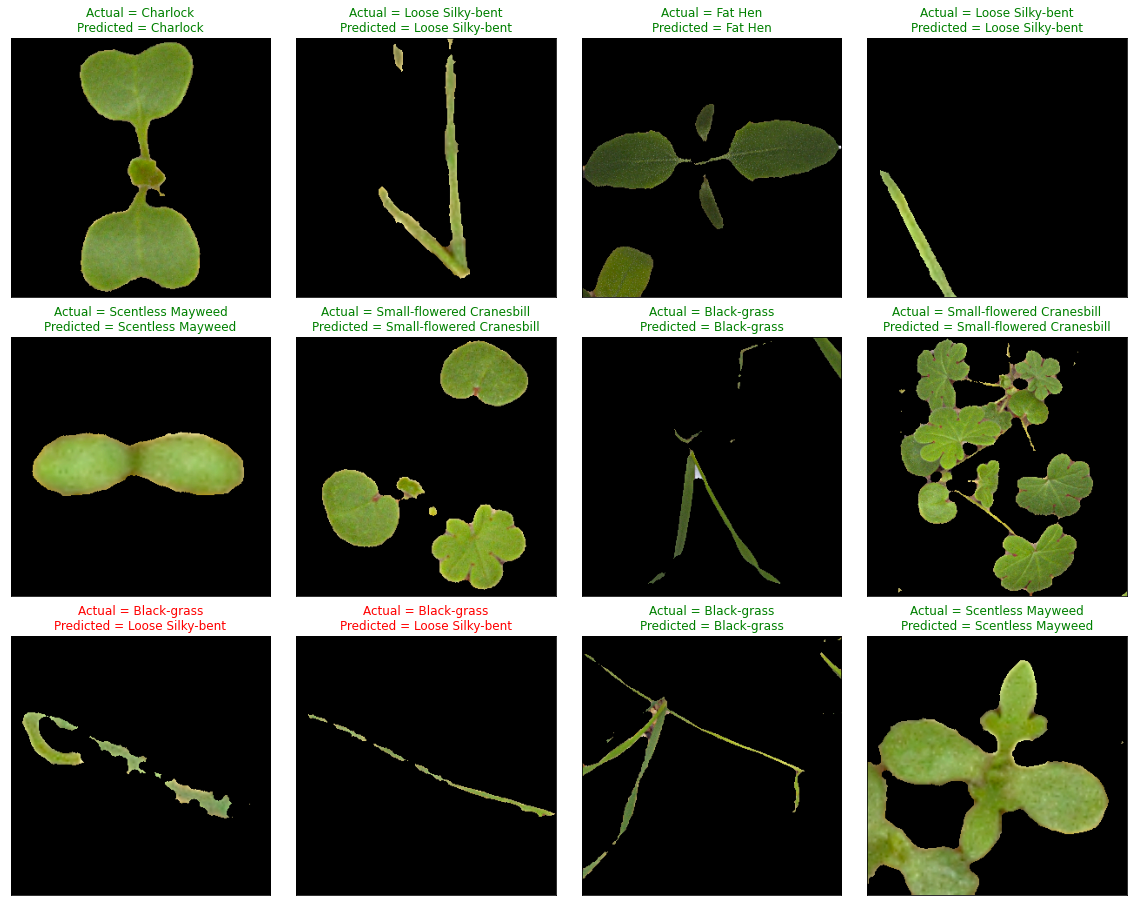

In [79]:
y_true_s = [labels[x] for x in val_y]
y_pred_s = [labels[x] for x in classifier[best_classifier][1]]

fig = plt.figure(1, figsize=(20,16))
test_idxs = np.arange(len(val_x))
np.random.shuffle(test_idxs)
picks = test_idxs[:12]
for i, r in enumerate(picks):
    batch_r = r // batch_size
    idx_r = r % batch_size
    plt.subplot(3,4,i+1)
    plt.subplots_adjust(hspace = 0.1, wspace = 0.1)
    plt.imshow(tf.keras.utils.array_to_img(val_x[r]))
    plt.title('Actual = {}\nPredicted = {}'.format(y_true_s[r], y_pred_s[r]), color= 'green' if y_true_s[r] == y_pred_s[r] else 'red')
    plt.xticks([]) , plt.yticks([])
    
plt.show()

# Submission

In [80]:
test_x = np.zeros((len(test), img_width, img_height, 3), dtype='float32')
for i, file in tqdm(enumerate(test['filepath'])):
    img = cv2.imread(file)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (img_width, img_height))
    img = preprocessing_cnn(img, mask_grass=detourage, nl_means=nl_means)
    img = tf.keras.utils.img_to_array(img)
    x = preprocess_input(np.expand_dims(img, axis=0))
    test_x[i] = x
print('Test Images shape: {} size: {:,}'.format(test_x.shape, test_x.size))

794it [00:08, 89.24it/s]

Test Images shape: (794, 299, 299, 3) size: 212,953,182


In [88]:
raw_test_x = np.zeros((len(test), 6075), dtype='float32')
for i, file in tqdm(enumerate(test['filepath'])):
    img = cv2.imread(file)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (45, 45))
    img = preprocessing_cnn(img, mask_grass=detourage, nl_means=nl_means)
    img = tf.keras.utils.img_to_array(img)
    img = img.flatten()
    x = preprocess_input(np.expand_dims(img, axis=0))
    raw_test_x[i] = x
print('Train Images shape: {} size: {:,}'.format(raw_test_x.shape, raw_test_x.size))

794it [00:17, 45.54it/s]

Train Images shape: (794, 6075) size: 4,823,550


In [95]:
for key in pure_classifier:
    test_preds = pure_classifier[key][0].predict(raw_test_x)
    if key == 'raw fc':
        test_preds = np.argmax(test_preds, axis=1)
    test['category_id'] = test_preds
    test['species'] = [labels[c] for c in test_preds]
    output_file = f'submission {key}.csv'
    test[['file', 'species']].to_csv(output_file, index=False)

In [96]:
test_x_bf = transfer_model.predict(test_x, batch_size=batch_size, verbose=1)
print('Xception test bottleneck features shape: {} size: {:,}'.format(test_x_bf.shape, test_x_bf.size))
for key in classifier:
    test_preds = classifier[key][0].predict(test_x_bf)
    if key == 'fc':
        test_preds = np.argmax(test_preds, axis=1)
    test['category_id'] = test_preds
    test['species'] = [labels[c] for c in test_preds]
    output_file = f'submission Xception + {key}.csv'
    test[['file', 'species']].to_csv(output_file, index=False)

50/50 [==============================] - 144s 3s/step
Xception test bottleneck features shape: (794, 2048) size: 1,626,112


In [97]:
print("Total Notebook time: {} sec".format((dt.datetime.now()-start).seconds))

Total Notebook time: 12341 sec
